# Meine Trainingsdaten

In dieser Datei, erstelle ich zwei Modelle. <br>
 - Eines, welches anhand der angegebenen Geschwindigkeit und der Laufstrecke die Anstrengung während des Laufens vorhersagt, <br>
 - und ein anderes, welche die drei Paramter `Strecke in km`, `m/s` und `Empfinden` annimmt, und somit die maximale durchschnittliche Herzfrequenz hervorsagt, <br>welche während diesem Lauf nicht überschritten werden sollte.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns

from tensorboard import notebook
import datetime

import sklearn.metrics
from sklearn.preprocessing import StandardScaler
import shap


tf.__version__

'2.8.2'

In [2]:
# Laden der TensorBoard extension
%load_ext tensorboard

## Data

Um das Modell zu trainieren werde ich meine Trainingsdaten aufteilen in die verschiedenen Trainingsbereiche, die Trainingsphasen, <br>
die jeweiligen Wochenkilometer und die Geschwindigkeit spezifischer Ausdauerprogramme:

feature| Description| Feature Type
------------|--------------------|----------------------
Strecke in km | Laufstrecke in KM | Numerical
Empfinden | Die Empfundene Anstrengung während des Laufens auf einer Skala von 0 bis 10 | Numerical
m/s | Die durchschnittliche Geschwindigkeit in m/s | Numerical
Herzfrequenz | Die durchschnittliche Herzfrequenz | Numerical

### Data import

- Hier Lade ich die Daten zunächst in einen Pandas Dataframe

- Welches Modell man jetzt Trainineren will, hängt davon ab, welchen Codeblock man laufen lässt.
- Ich fokussiere mich in diesem Notenbook auf das Herzfrequenzmodell (Trainingsdaten_VS)

In [3]:
#Einlesen der CSV
dfTR = pd.read_csv("Trainingsdaten_060522.csv", sep=",")

In [4]:
dfTR = pd.read_csv("Trainingsdaten_VS.csv", sep=",")

In [5]:
dfTR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       713 non-null    object 
 1   Datum      713 non-null    object 
 2   Woche      713 non-null    object 
 3   Bereich    713 non-null    object 
 4   Kategorie  713 non-null    object 
 5   Typ        102 non-null    object 
 6   Programm   713 non-null    object 
 7   HF         713 non-null    object 
 8   Laktat     11 non-null     float64
 9   Empfinden  713 non-null    object 
 10  Bemerkung  136 non-null    object 
dtypes: float64(1), object(10)
memory usage: 61.4+ KB


### Data Preparation

- Zuerst wird die Spalte Woche aufgeteilt in `KW` und `Jahr`, damit man damit später auch rechnen kann

In [6]:
#Woche in KW und Jahr unterteilen
dfWoche = dfTR["Woche"].str.split("/", n=2, expand=True)
dfTR["KW"] = dfWoche[0]
dfTR["Jahr"] = dfWoche[1]

- Zur besseren Übersicht, werden vorerst unnötige Spalten aus dem Dataframe entfernt

In [7]:
#Löschen der unnötigen Spalten
dfTR.drop(["Laktat", "Bemerkung", "Name"], axis=1, inplace=True)

- Dann wird nach den Dauerläufen im Bereich `GA1` und `GA2/KA Schwelle` mit dem filter `flach (L)` sortiert, damit die Tempolaufprogramme aus dem Dataframe gefiltert werden
- Diese Sortierung wird unserer finalen `df` variable zugewiesen

In [8]:
#nur nach GA1 und GA2 schnelle Dauerläufe sortiert
df = dfTR[(dfTR["Bereich"] == "GA1") | (dfTR["Bereich"] == "GA2/KA Schwelle") & (dfTR["Kategorie"] == "flach (L)")]

In [9]:
df.head()

,Datum,Woche,Bereich,Kategorie,Typ,Programm,HF,Empfinden,KW,Jahr
0,16.05.2022,20/22,GA1,flach (L),NaN,8 km | 4.44 m/s | 3:45 min/km,-/-,3 - moderat,20,22
1,15.05.2022,19/22,GA1,profiliert (L),NaN,18.9 km | 3.94 m/s | 4:14 min/km,-/-,2 - leicht,19,22
4,14.05.2022,19/22,GA2/KA Schwelle,flach (L),NaN,8 km | 5.08 m/s | 3:17 min/km,-/-,5 - anstrengend,19,22
6,12.05.2022,19/22,GA1,flach (L),NaN,10 km | 4.2 m/s | 3:58 min/km,-/-,3 - moderat,19,22
8,11.05.2022,19/22,GA1,profiliert (L),NaN,6 km | 4.17 m/s | 4:00 min/km,-/-,2 - leicht,19,22


- Wie der überliegenden Tabelle zu entnehmen ist, ist der Dataframe noch nicht ganz lesbar für unser Modell
- Die Spalte `Programm` wird also im folgenden aufgesplittet, und in mehrere Spalten unterteilt
- Des weiteren wird auch die Spalte `HF` (Herzfrequenz) aufgeteilt

In [10]:
# Programm in zwei gesplittet und Programm gelöscht
new = df["Programm"].str.split("|", n=1, expand=True)
df.drop(columns=["Programm"], inplace=True)

# Aus den ersten zwei teilen Strecke und Pace gemacht
df["Strecke in km"] = new[0]
df["Pace"] = new[1]

# Aus Pace nochmal zwei teile gemacht und Pace gelöscht
newkmh = df["Pace"].str.split("|", n=1, expand=True)
df.drop(columns=["Pace"], inplace=True)

# Meter pro sekunde und min/km als Spalte hinzugefügt
df["m/s"] = newkmh[0]
df["min/km"] = newkmh[1]

# HF wird in zwei gesplittet und die Spalte HF im Dataframe gelöscht
hf = df["HF"].str.split("/", n=1, expand=True)
df.drop("HF", axis=1, inplace=True)

# Die zwei Teile werden df hinzugefügt
df["AVG_HF"] = hf[0]
df["MAX_HF"] = hf[1]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

- In meinem Datenset sind bei einigen Feldern keine Herzfrequenz eingetragen
- Diese müssen aussortiert werden

In [11]:
df = df.drop(df[df["AVG_HF"] == "-"].index)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 69 to 374
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Datum          46 non-null     object
 1   Woche          46 non-null     object
 2   Bereich        46 non-null     object
 3   Kategorie      46 non-null     object
 4   Typ            11 non-null     object
 5   Empfinden      46 non-null     object
 6   KW             46 non-null     object
 7   Jahr           46 non-null     object
 8   Strecke in km  46 non-null     object
 9   m/s            46 non-null     object
 10  min/km         46 non-null     object
 11  AVG_HF         46 non-null     object
 12  MAX_HF         46 non-null     object
dtypes: object(13)
memory usage: 5.0+ KB


In [13]:
df.tail()

,Datum,Woche,Bereich,Kategorie,Typ,Empfinden,KW,Jahr,Strecke in km,m/s,min/km,AVG_HF,MAX_HF
296,16.09.2021,37/21,GA1,profiliert (L),NaN,3 - moderat,37,21,15.8 km,3.79 m/s,4:24 min/km,168,186
298,15.09.2021,37/21,GA1,flach (L),NaN,3 - moderat,37,21,12 km,3.69 m/s,4:31 min/km,162,187
299,14.09.2021,37/21,GA1,flach (L),NaN,2 - leicht,37,21,10.3 km,3.82 m/s,4:22 min/km,165,179
302,09.09.2021,36/21,GA1,profiliert (L),NaN,4 - etwas anstrengend,36,21,10.1 km,4.08 m/s,4:05 min/km,179,193
374,18.06.2021,24/21,GA1,profiliert (L),NaN,3 - moderat,24,21,12.9 km,3.77 m/s,4:25 min/km,161,-


- Die Einheiten werden noch Entfernt
- Und als nächstes werden die numerischen Felder in `float` und die textfelder in `str` umgewandelt

In [14]:
#Entfernen der Einheiten und Umwandeln der Datenfelder in float
df["Strecke in km"] = df["Strecke in km"].str.replace(r"km", "").astype(float)
df["m/s"] = df["m/s"].str.replace(r"m/s", "").astype(float)
df["min/km"] = df["min/km"].str.replace(r"min/km", "").astype(str)

In [15]:
df.head()

,Datum,Woche,Bereich,Kategorie,Typ,Empfinden,KW,Jahr,Strecke in km,m/s,min/km,AVG_HF,MAX_HF
69,24.03.2022,12/22,GA1,profiliert (L),NaN,3 - moderat,12,22,11.9,3.75,4:27,150,175
86,15.03.2022,11/22,GA2/KA Schwelle,flach (L),NaN,5 - anstrengend,11,22,10.0,4.93,3:23,177,188
87,14.03.2022,11/22,GA1,profiliert (L),NaN,4 - etwas anstrengend,11,22,8.5,4.20,3:58,158,179
88,14.03.2022,11/22,GA1,profiliert (L),NaN,2 - leicht,11,22,12.3,3.55,4:42,151,179
92,11.03.2022,10/22,GA1,profiliert (L),NaN,3 - moderat,10,22,12.0,3.45,4:50,147,169


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 69 to 374
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datum          46 non-null     object 
 1   Woche          46 non-null     object 
 2   Bereich        46 non-null     object 
 3   Kategorie      46 non-null     object 
 4   Typ            11 non-null     object 
 5   Empfinden      46 non-null     object 
 6   KW             46 non-null     object 
 7   Jahr           46 non-null     object 
 8   Strecke in km  46 non-null     float64
 9   m/s            46 non-null     float64
 10  min/km         46 non-null     object 
 11  AVG_HF         46 non-null     object 
 12  MAX_HF         46 non-null     object 
dtypes: float64(2), object(11)
memory usage: 5.0+ KB


### Data format

- Jetzt müssen wir unsere Daten noch ein weniger weiter formatieren

- Die Spalte `AVG_HF` wird in int umgewandelt und `MAX_HF` wird entfernt

In [17]:
df["AVG_HF"] = df["AVG_HF"].astype("int")
df.drop("MAX_HF", axis=1, inplace=True)

- Aus Performancegründen wandeln wir folgende Werte um:

  - `int64` in `int32`
  - `float64` in `float32` 

In [18]:
# Erstellen eines dictionarys mit int64 Spalten als keys und np.int32 als werte
int_32 = dict.fromkeys(df.select_dtypes(np.int64).columns, np.int32)
# Alle spalten in dem dictionary verändern
df = df.astype(int_32)

# Erstellen eines dictionarys mit float64 Spalten als keys und np.float32 als werte
float_32 = dict.fromkeys(df.select_dtypes(np.float64).columns, np.float32)
df = df.astype(float_32)

In [19]:
float_32

{'Strecke in km': numpy.float32, 'm/s': numpy.float32}

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 69 to 374
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Datum          46 non-null     object 
 1   Woche          46 non-null     object 
 2   Bereich        46 non-null     object 
 3   Kategorie      46 non-null     object 
 4   Typ            11 non-null     object 
 5   Empfinden      46 non-null     object 
 6   KW             46 non-null     object 
 7   Jahr           46 non-null     object 
 8   Strecke in km  46 non-null     float32
 9   m/s            46 non-null     float32
 10  min/km         46 non-null     object 
 11  AVG_HF         46 non-null     int32  
dtypes: float32(2), int32(1), object(9)
memory usage: 4.1+ KB


- Als nächstes wandeln wir die kategorischen Daten in numerische um

In [21]:
df["Empfinden"] = df["Empfinden"].replace(["0 - Ruhe", "1 - sehr leicht", "2 - leicht", "3 - moderat", "4 - etwas anstrengend", 
"5 - anstrengend", "6", "7 - sehr anstrengend", "8", "9 - extrem anstrengend", "10 - maximale ausbelastung"], ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]).astype(int)

- Als nächstes erstelle ich eine weitere CSV, wo das datum noch enthalten ist, damit ich damit später in Streamlit arbeiten kann
- Hier ist das Datum allerdings zunächst unnötig

In [22]:
df.drop(["Bereich", "Kategorie", "Typ", "min/km", "Woche"], axis=1, inplace=True)
df.to_csv("cleaned_data.csv", index=False)

- Hier entferne ich für eine bessere Übersicht, die temporär unwichtigen Spalten, damit sich für mein Modell nur meine vier wichtigen Variablen im df befinden

In [23]:
df.drop(["KW", "Jahr", "Datum"], axis=1, inplace=True)

- Die folgende csv ist für die Datenvisualisierung des Anstrengungsmodelles in Streamlit da, und ist somit für einen Durchlauf des Herzfrequenzmodelles irrelevant 

In [24]:
df.to_csv("anstregung.csv", index=False)

In [25]:
df.head()

,Empfinden,Strecke in km,m/s,AVG_HF
69,3,11.9,3.75,150
86,5,10.0,4.93,177
87,4,8.5,4.20,158
88,2,12.3,3.55,151
92,3,12.0,3.45,147


- Der fertig präparierte Dataframe hat jetzt 46 Zeilen und 4 Spalten
- Aufgrund meiner Datenlage kann man das Modell nicht als Aussagekräftig bezeichnen, jedoch ist die Funktion genau die selbe

In [26]:
df.shape

(46, 4)

In [27]:
df.tail()

,Empfinden,Strecke in km,m/s,AVG_HF
296,3,15.8,3.79,168
298,3,12.0,3.69,162
299,2,10.3,3.82,165
302,4,10.1,4.08,179
374,3,12.9,3.77,161


### Data Visualization

- Als nächstes können wir uns die Daten visualisieren lassen.

- Als generelle Übersicht vor einer Visualisierung ist es gut, einen Blick auf die Statistische Auswertung der Daten zu werfen. 
- Dies funktioniert sehr gut mit der pandas funktion `Dataframe.describe()`

In [28]:
df.describe()

,Empfinden,Strecke in km,m/s,AVG_HF
count,46.000000,46.000000,46.000000,46.000000
mean,3.869565,11.689783,4.168478,165.130435
std,1.600121,4.392348,0.503812,11.422412
min,2.000000,4.340000,3.360000,145.000000
25%,3.000000,8.500000,3.797500,158.000000
50%,3.000000,11.630000,4.080000,165.500000
75%,4.750000,14.837500,4.582500,173.000000
max,8.000000,22.799999,5.240000,188.000000


#### Visuelle Darstellung mit Seaborn

- Mit Pandas lässt sich der Dataframe allerdings nicht visuell darstellen lassen. Dafür benutze ich Seaborn
- Seaborn ist eine Python Datenvisualisierungsbibliothek, auf der Basis von matplotlib
- Sie ermöglicht mit einfachen Befehlen einen sehr guten Überblick über eventuelle Abhängigkeiten zu erhalten

- Hier bekommt man schon einen guten Überblick darüber, welche Features in Abhängigkeit stehen

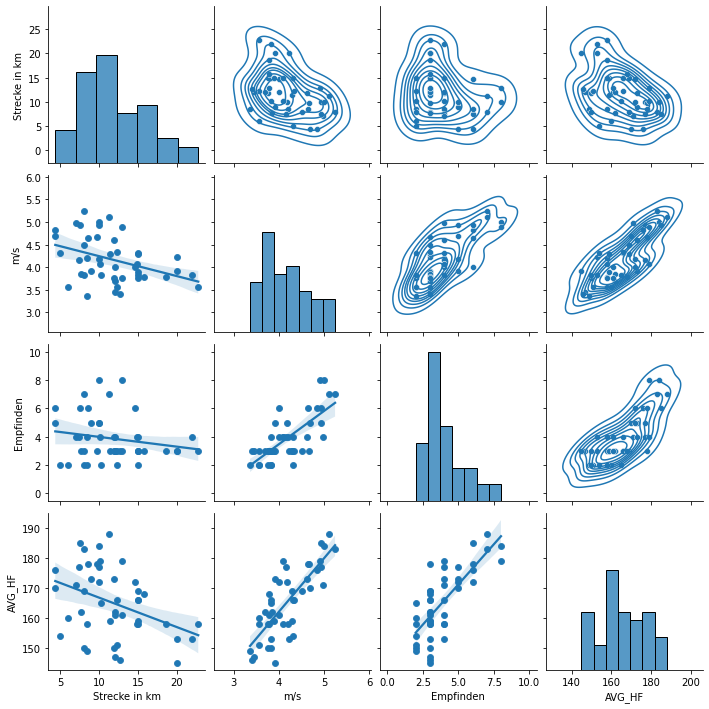

In [29]:
# Auflisten der vier features in sns.pairplot
pp = sns.pairplot(df[["Strecke in km", "m/s", "Empfinden", "AVG_HF"]])
pp = pp.map_lower(sns.regplot)
pp = pp.map_upper(sns.kdeplot)

### Data Splitting

- Als ersten Schritt wird die zu vorhersagende Variable in einer Kopie mit der Variable `X` aus dem Dataframe entfernt
- Als zweites wird eine weitere Kopie des Dataframes mit der Variable `y` initiiert, welche nur die target variable enthält

In [30]:
# Dieses Codeelement wird nur für das Anstrengungsmodell benutzt
#X = df.drop(["Empfinden"], axis=1)
#y = df["Empfinden"]

In [31]:
X = df.drop(["AVG_HF"], axis=1)
y = df["AVG_HF"]

- Mit hilfe der sklearn-Methode `train-test-split()` werden jetzt die zwei Dataframes in vier verschiedene Variablen unterteilt
- Hierbei beträgt die split-size 20% der Daten

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [33]:
print(
    "%d Datensätze werden für das Training benutzt, und %d für die validation"
    %(len(X_train), len(X_test))
)

36 Datensätze werden für das Training benutzt, und 10 für die validation


## Model

- Ich benutze bei meinem Modell ein Sequentielles Modell
- Dieses Modell benutzt man dann, wenn es einen Input und einen Output des Modells gibt


- Zuerst wird hier das Sequentielle keras Modell instanziiert

In [34]:
model = tf.keras.Sequential()

- In meinem Fall benutze ich 9 Knoten im ersten Layer, mit `input_dim=3`, da ich in meinem Test dem Modell 3 Input Features übergebe
- Mein Output Layer hat dann nur noch einen Output, da ich nur versuche vorherzusagen, welche durschnittliche Herzfrequenz man während dem Dauerlauf nicht überschreiten sollte.

In [35]:
# Erster Layer
model.add(tf.keras.layers.Dense(9, input_dim=3, activation="relu"))
# Zweiter Layer
model.add(tf.keras.layers.Dense(6, activation="relu"))
# Dritter Layer
model.add(tf.keras.layers.Dense(3, activation="relu"))
# Output Layer
model.add(tf.keras.layers.Dense(1, activation="linear"))

In [36]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(3, 9) dtype=float32, numpy=
 array([[-0.6527601 , -0.51858073,  0.0751217 ,  0.2711364 ,  0.18629986,
          0.20429182,  0.18532962, -0.5775826 ,  0.43179518],
        [-0.5890578 ,  0.2534904 , -0.09198803,  0.08929098,  0.12106144,
         -0.3302755 , -0.21994871,  0.5074133 , -0.42565972],
        [-0.64249194,  0.03099954, -0.4715197 ,  0.00571966,  0.28011924,
          0.43462366,  0.15908194,  0.61103255,  0.14750707]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(9,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(9, 6) dtype=float32, numpy=
 array([[-0.14421761,  0.01426739, -0.60440195,  0.37440318,  0.52743584,
          0.39955765],
        [-0.60399467, -0.48870444,  0.2839545 , -0.42387298, -0.2674285 ,
         -0.52867293],
        [ 0.01888305, -0.47329864,  0.00749618,  0.48689443,  0.136765  ,
          0.60759264],
        [ 0.44804972

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 36        
                                                                 
 dense_1 (Dense)             (None, 6)                 60        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


- Mit Keras Model.compile() wird das Modell dann konfiguriert.

In [38]:
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])

- Hier wird für das Tensorbard das logs verzeichnis erstellt

In [39]:
# Create TensorBoard folders
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

##### Callbacks
- Für mein Modell lege ich außerdem Callbacks fest. 
- Callbacks sind dafür da, bestimme Aktionen in verschiedensten Phasen des Trainings durchzuführen.
- In meinem Fall führe ich ein Tensorboard aus, um die Ergebnisse später gut visualisieren zu können
- Des weiteren implementiere ich einen EarlyStopping Callback, um Overfitting zu vermeiden. 
- Nachdem sich der `val_loss` nach 15 Durchläufen nicht verbessert hat, wird das Training unterbrochen

In [40]:
my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
]

## Training

- Hier wird das Modell dann der Variable test_history zugeordnet, trainiert und getestet
- Ich habe mich in meinem normalen durchlauf und dem Training für 2000 Epochen nach etwas probieren entschieden, weil ich so auf augenscheinlich gute ergebnisse gestoßen bin

In [41]:
test_history = model.fit(X_train, y_train, epochs=2000, validation_split=0.2, verbose=1, callbacks=my_callbacks)

Epoch 1/2000
1/1 [==============================] - 1s 636ms/step - loss: 28093.4590 - mse: 28093.4590 - mae: 167.1971 - val_loss: 26913.7305 - val_mse: 26913.7305 - val_mae: 163.5829
Epoch 2/2000
1/1 [==============================] - 0s 33ms/step - loss: 28091.3613 - mse: 28091.3613 - mae: 167.1908 - val_loss: 26911.7227 - val_mse: 26911.7227 - val_mae: 163.5768
Epoch 3/2000
1/1 [==============================] - 0s 28ms/step - loss: 28089.2324 - mse: 28089.2324 - mae: 167.1845 - val_loss: 26909.6367 - val_mse: 26909.6367 - val_mae: 163.5704
Epoch 4/2000
1/1 [==============================] - 0s 33ms/step - loss: 28087.0664 - mse: 28087.0664 - mae: 167.1780 - val_loss: 26907.4805 - val_mse: 26907.4805 - val_mae: 163.5639
Epoch 5/2000
1/1 [==============================] - 0s 30ms/step - loss: 28084.8730 - mse: 28084.8730 - mae: 167.1715 - val_loss: 26905.2852 - val_mse: 26905.2852 - val_mae: 163.5573
Epoch 6/2000
1/1 [==============================] - 0s 27ms/step - loss: 28082.6523 

- Ich lasse mein Modell hier ziemlich oft durchlaufen, und erziele dabei einen loss von 361
- Um zu überprüfen, wie sich mein Modell verhält, und ob ich dies verwenden kann, werde ich beim Hyperparameter Tuning erfahren.

### Hyperparameter Tuning

- Um mein Modell eventuell noch genauer zu machen, führe ich im Folgenden ein Hyperparameter Tuning durch
- Mir geht es hierbei darum, herauszufinden, mit welchen Parametern ich mein Modell verbessern kann.


In [42]:
import keras_tuner as kt

- Mithilfe der hp.Choice Funktion wird in dieser funktion beim Aufrufen jedes mal ein anderes Modell erzeugt.
- Das Modell wird kompiliert und zurückgegeben

In [43]:
def build_model(hp):
    model_hp = tf.keras.Sequential()
    model_hp.add(tf.keras.layers.Dense(
        hp.Choice('units', [8, 16, 32]),
        activation='relu'))
    model_hp.add(tf.keras.layers.Dense(1, activation='linear'))
    model_hp.compile(loss='mse', metrics=["mse", "mae"])
    return model_hp


- Ich führe hier einen RandomSearch durch.
- Dabei wird jede mögliche Kombination der verfügbaren Parameter durchprobiert.

In [44]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    project_name="hp_tuning"
    )

- Mit meinen Callbacks ist diese Einstellung zu unruhig, und es kommt zu einem EarlyStopping
- Der loss ist also höher, als bei meinem normal trainerten Modell.

- Dies suggeriert, dass mein normal trainertes Modell Overfittet ist. 

In [45]:
my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
]

In [46]:
tuner.search(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), callbacks=my_callbacks)
best_model = tuner.get_best_models()[0]

Trial 3 Complete [00h 00m 51s]
val_loss: 915.6578369140625

Best val_loss So Far: 618.0137939453125
Total elapsed time: 00h 01m 56s
INFO:tensorflow:Oracle triggered exit


- Mit `Patience=15` warte ich hier 15 Steps. Wenn das Modell dann nicht besser wird, bricht das Training ab.
- Overfitting wird bei meinem Hyperparameter Modell also vermieden.
- Mit einem loss von knapp 915 ist dieses Modell alles andere als genau, jedoch ist dies aufgrund der Datenmenge und Qualität nicht verwunderlich

### Modellwahl

- Ich entscheide mich für mein finales Modell also für das Beste aus meiner RandomSearch. 
- Dies liegt an erster Stelle der get_best_models funktion

In [47]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
# Get best model
best_model = models[0]

## Evaluierung 

- Im Folgenden werde ich das Modell mit einem Tensorboard, Matplotlib und Shap etwas genauer unter die Lupe nehmen.

- Laden einer Tensorboard instanz zur Visualisierung des Modells

In [48]:
%tensorboard --logdir . --port=6007

Reusing TensorBoard on port 6007 (pid 8676), started 10 days, 21:03:55 ago. (Use '!kill 8676' to kill it.)

In [49]:
notebook.list()

Known TensorBoard instances:
  - port 6009: logdir ./hp_tuning (started 10 days, 13:54:21 ago; pid 12212)
  - port 6006: logdir . (started 10 days, 21:05:06 ago; pid 18880)
  - port 6009: logdir /hp_tuning (started 10 days, 13:55:40 ago; pid 19748)
  - port 6010: logdir ./hp_tuning (started 10 days, 13:54:09 ago; pid 20264)
  - port 6008: logdir . (started 10 days, 13:56:45 ago; pid 21800)
  - port 6006: logdir log_dir (started 10 days, 21:06:11 ago; pid 7544)
  - port 6007: logdir . (started 10 days, 21:03:55 ago; pid 8676)


- Mit matplotlib.pyplot kann man sich den Fortschritt und die Entwicklung über das Training des Modells genau anschauen, ohne dabei eine tensorboard instanz zu starten:
- Den selben Überblick bekommt man jedoch natürlich nicht 
- Hier bilde ich nur mein normal trainiertes modell ab, um dies mit dem tensorboard modell vergleichen zu können

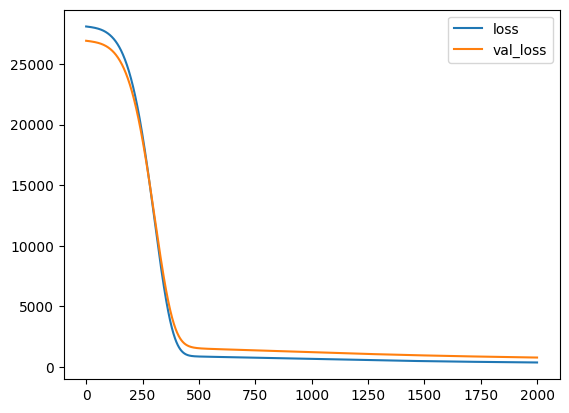

In [50]:
history_df = pd.DataFrame(test_history.history)
plt.plot(history_df["loss"], label="loss")
plt.plot(history_df["val_loss"], label="val_loss")

plt.legend()

### SHAP

- Mit SHAP lässt sich ein Modell sehr gut auswerten. 
- Man kann hier visualisieren, welche Werte sich wie stark auf das Modell auswirken.
- So fällt es einem leichter, die Funktionsweise des Modells und die Hintergründe verschiedenster Predictions leichter zu erkennen

In [61]:
shap.initjs()

- Hier ordne ich dem Shap Explainer zuerst eine Variable zu.
- Der Shap Explainer ist das primäre Explainer Interface von Shap. 
- Diesem übergeben wir unser Modell und unsere Daten

In [62]:
explainer = shap.Explainer(best_model.predict, X)

- Der `shap_values` variable übergeben wir jetzt das explainer Objekt mit unseren Daten

In [63]:
shap_values = explainer(X)

- Als erstes lasse ich hier einen Bar Plot mit dem Mittelwert des sogenannten `SHAP values` ausgeben
- Dieser Wert zeigt die Auswirkung des Wertes auf das Modell an.
- Je höher der Wert, desto größer der Einfluss dieses Features auf die Prediction des Modells

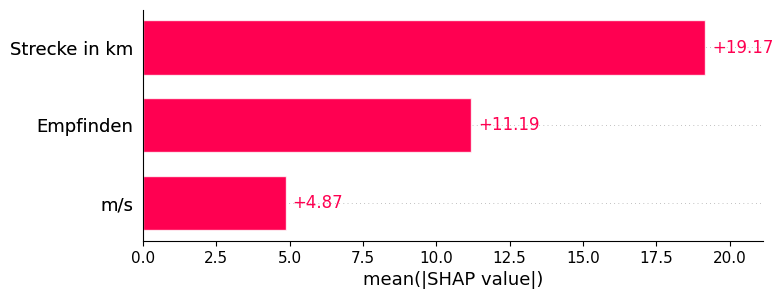

In [66]:
shap.plots.bar(shap_values)

- Was bei meinem Modell heraussticht, ist vor allem erst die `Strecke in km`
- Dies ist auch das erste Learning bei meiner Modellanalyse.
- Je länger die Strecke, desto höher die durchschnittliche Herzfrequenz. 
- Mathematisch macht dies auch Sinn, da bei einer längeren Belastung der Schnitt im allgemeinen höher ist. 
- Würde man bei einer 30 min Belastung auf einen Puls von 180 kommen und diesen halten, hat man natürlich dann bei einer 60 minuten Belastung einen höheren Gesamtschnitt.
- Der Wert dieser Variable ist also sehr wichtig für die Prediction, wie man auch im folgenden Summary Plot erkennen kann

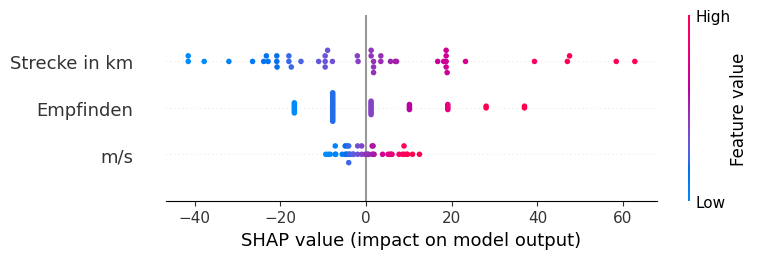

In [67]:
shap.summary_plot(shap_values)

- Der Violin Plot ist eigentlich der selbe, wie deer Summary Plot, jedoch finde ich die Darstellung noch etwas anschaulicher, da man einen besseren Überblick bekommt, wo sich die meisten Werte ansiedeln.
- Auch das `Empfinden` hat einen ziemlich hohen SHAP value.
- Dies lässt mich darauf schließen, dass die Herzfrequenz weniger von der Geschwindigkeit, sondern eher von der Tagesform und dem Gefühl beim Laufen abhängig ist.
- Dieser Fakt macht es natürlich deutlich schwieriger Leistungen vorherzusagen, da man diese nicht an der Geschwindigkeit messen kann, sondern an ganz vielen anderen Faktoren

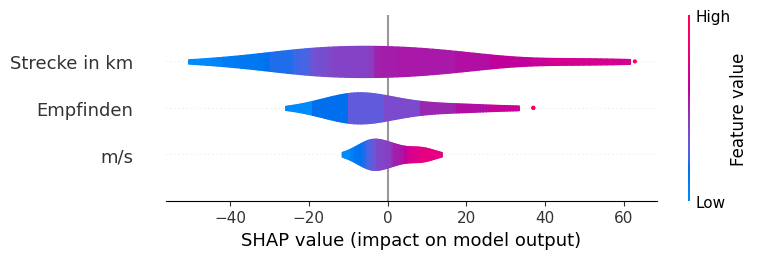

In [68]:
shap.summary_plot(shap_values, plot_type="violin")

## Testing 

- Als letztes gilt es das Modell zu testen.
- Mit Shap und dem vorigen Kapitel haben wir dies ja auch schon getan.
- In diesem Kapitel werden noch ein paar Zahlen gezeigt, das Modell ausgetestet und außerdem abgespeichert, damit ich in der app.py darauf zugreifen kann

- Mit der .evaluate funktion kann man das Modell gut auswerten

In [71]:
best_model.evaluate(X_test, y_test, batch_size=16)

1/1 [==============================] - 0s 18ms/step - loss: 618.0138 - mse: 618.0138 - mae: 18.3671


[618.0137939453125, 618.0137939453125, 18.36709213256836]

- Auch ein Graph kann helfen, die Genauigkeit eines Modells abzubilden, indem man die echten Werte mit den vorhergesagten Vergleicht:

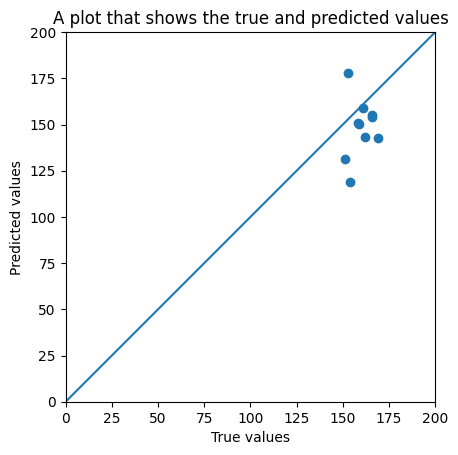

In [72]:
y_pred = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('A plot that shows the true and predicted values')
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.plot([0, 200], [0, 200])

- Hier lasse ich mir kurz einen Auszug aus dem Dataframe geben, damit ich die Reihenfolge der zu übergebenden Variablen im testing sehen kann

In [73]:
df.head()

,Empfinden,Strecke in km,m/s,AVG_HF
69,3,11.9,3.75,150
86,5,10.0,4.93,177
87,4,8.5,4.20,158
88,2,12.3,3.55,151
92,3,12.0,3.45,147


- Als nächtes generiere ich einen test input mit erfundenen Variablen für die Werte [`Empfinden`, `Strecke in km`, `m/s`]

In [74]:
new_input = [[3, 8, 3.7]]

- Mit diesem test input kann ich jetzt das Modell testen, um zu sehen, welche `AVG_HF` vorhergesagt wird
- Dies hilft mir dabei zu visualisieren, wie der Benutzer später in Streamlit die Daten übergeben sollte

In [75]:
new_output = best_model.predict(new_input)
print(new_output)

[[125.93431]]


- Das Modell wird abgespeichert, damit es in der app.py direkt aufgerufen werden kann, ohne weitere Berechnungen durchführen zu müssen
- Ich speichere hier außerdem auch mein altes Modell vor dem Hyperparameter tuning, um für mich Vergleichswerte zu haben

In [76]:
best_model.save("best_model")

INFO:tensorflow:Assets written to: best_model\assets


In [77]:
model.save("hf_model")

INFO:tensorflow:Assets written to: hf_model\assets


- Dasselbe gilt für das Anstrengungsmodell, falls man dieses bearbeiten möchte.

In [44]:
model.save("feeling_model")

INFO:tensorflow:Assets written to: feeling_model\assets


In [45]:
model = tf.keras.models.load_model("feeling_model")